# Understanding rosettes and MBONs
no KC specificity unless otherwise indicated

In [1]:
%pylab inline
import seaborn as sns
import numpy as np
import pandas as pd
import cPickle as pickle
from irm import cvpipelineutil
import sklearn.neighbors
import scipy.sparse
import irm
import scipy.stats
from matplotlib.collections import LineCollection
sns.set(style="white", context="talk")


Populating the interactive namespace from numpy and matplotlib


In [2]:
neurons_data = pickle.load(open("../data/mushroombody.neurondf.pickle", 'r'))
synapse_data = pickle.load(open("../data/mushroombody.synapsesdf.pickle", 'r'))
basicmat_data = pickle.load(open("../data/mushroombody.cleandata.pickle", 'r'))
tbar_df = synapse_data['tbar_df']
connections_df = synapse_data['connections_df']
neurons_df = neurons_data['neurondf']


# Rosette definition and distances


In [3]:
dfmerged = pd.merge( connections_df, tbar_df, left_on='tbar_id', 
                    right_on='id', suffixes=('_post', '_pre'))
dfmerged.convergent = dfmerged.convergent == 'convergent'
dfmerged.dtypes

body ID_post         int64
confidence_post    float64
flagged_post        object
loc_x_post           int64
loc_y_post           int64
loc_z_post           int64
tbar_id              int64
traced                bool
user_post           object
body ID_pre          int64
confidence_pre     float64
convergent            bool
flagged_pre         object
id                   int64
loc_x_pre            int64
loc_y_pre            int64
loc_z_pre            int64
multi               object
status              object
user_pre            object
dtype: object

In [4]:

neuronsdf = neurons_df.set_index('body ID')

vc = dfmerged['body ID_post'].value_counts()
neuronsdf['post_syn_count'] = vc

neuronsdf['name_clean'] = neuronsdf.name.apply(lambda x: str(x))
neuronsdf['celltype'] = neuronsdf.name_clean
neuronsdf.loc[neuronsdf.celltype == 'nan', 'celltype'] = ""
neuronsdf.loc[neuronsdf.celltype.str.contains("PAM"), 'celltype'] = 'PAM'
neuronsdf.loc[neuronsdf.celltype.str.contains("PPL"), 'celltype'] = 'PPL'
neuronsdf.loc[neuronsdf.celltype.str.contains("MBON"), 'celltype'] = 'MBON'
# now filter dfmerged such that we only have cells whose presynaptic cells and postsynaptic cells are in neuronsdf

dfmerged = dfmerged[dfmerged['body ID_pre'].isin(neuronsdf.index.values)]
dfmerged = dfmerged[dfmerged['body ID_post'].isin(neuronsdf.index.values)]

#kcs_df = neuronsdf[neuronsdf.name_clean.str.contains('KC')]
#kcs_bodyids = kcs_df.index.values
# srini says only convergent-annotated synapses should be used

In [5]:
#dfmerged_mbon_post = dfmerged[dfmerged['body ID_pre'].isin(kcs_bodyids)].copy()
MBON_neurons = neuronsdf[neuronsdf.name_clean.str[:4] == 'MBON']

In [6]:
dfmerged.convergent.value_counts()

True     167560
False     44742
Name: convergent, dtype: int64

In [7]:
dfmerged_mbon_post = dfmerged[dfmerged['body ID_post'].isin(MBON_neurons.index.values)].copy()


In [8]:
counts = dfmerged_mbon_post.pivot_table(index='body ID_post', columns='convergent', 
                                               values='id', aggfunc=lambda x : len(x))
counts['total'] = counts[False] + counts[True]
counts = counts.sort_values('total', ascending=False)
counts

convergent    False   True  total
body ID_post                     
10563          1595  12610  14205
54977          1642  12293  13935
616459         1081  11215  12296
3878341        1740   7939   9679
3338684        1654   7872   9526
3391197         437   3541   3978
1661302         261   1282   1543
149383611       184    718    902
8101328         136    646    782
1190582         290    350    640
5189028          22    122    144
2089450          62     75    137
4834094           7     76     83
8862577          13     12     25

In [9]:
MBON_ORDER = [MBON_neurons.ix[a].name_clean for a in counts.index.values]
MBON_ORDER

['MBON-14-B',
 'MBON-14-A',
 'MBON-18',
 'MBON-07-B',
 'MBON-07-A',
 'MBON-X',
 'MBON-19-A',
 'MBON-10?',
 'MBON-19-B',
 'MBON-06',
 'MBON-17-A-alpha prime',
 'MBON-11-R',
 'MBON-17-B-alpha prime',
 'MBON-11-L']

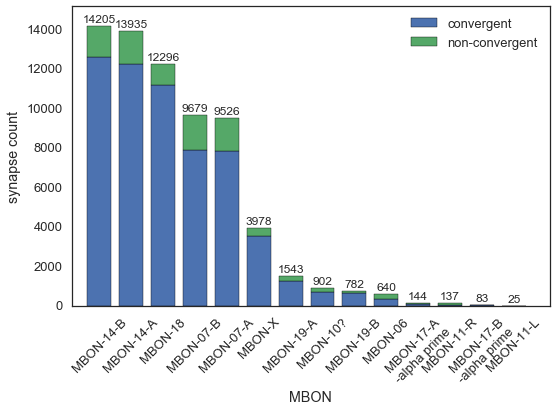

In [10]:
current_palette = sns.color_palette()
fig = pylab.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ind = np.arange(len(counts))
width = 0.75
p1 = ax.bar(ind, np.array(counts[True]), width, color=current_palette[0], label='convergent')
p2 = ax.bar(ind, np.array(counts[False]), width,color=current_palette[1],  label='non-convergent',
             bottom=np.array(counts[True]))
for i in ind:
    c = counts.iloc[i]
    ax.text(i + width/2, c.total + 200, str(c.total), horizontalalignment='center', fontsize=12)
pylab.legend()
ax.set_ylabel('synapse count')
ax.set_xlabel('MBON')
ax.set_xticks(ind + width/2.0)
names = [MBON_neurons.ix[a].name_clean for a in counts.index.values]
for i in range(len(counts)):
    if '-alpha' in names[i]:
        names[i] = names[i].replace("-alpha", "\n-alpha")
    
ax.set_xticklabels(names, rotation=45)
ax.set_ylim(0, 15200)
ax.set_xlim(-0.5, len(counts)+0.5)
ax.grid(0)
fig.tight_layout()
fig.savefig("MBON rosette datascience.synapses_per_mbon.pdf")

In [11]:
# are all the pre-ids in neuronsdf? 
for k, v in dfmerged_mbon_post['body ID_pre'].value_counts().iteritems():
    if k not in neuronsdf.index:
        print k, v

In [12]:
dfmerged_mbon_post['name_clean_pre'] = dfmerged_mbon_post['body ID_pre'].apply(lambda x : neuronsdf.ix[x].name_clean)
dfmerged_mbon_post['celltype_pre'] = dfmerged_mbon_post['body ID_pre'].apply(lambda x : neuronsdf.ix[x].celltype)

In [13]:
for ncp, df in dfmerged_mbon_post.groupby('celltype_pre'):
    if len(df) > 1000:
        a = df['body ID_pre'].value_counts()
        pylab.loglog(np.sort(a)[::-1], label=ncp, linewidth=3)
        pylab.ylabel("number of postsynaptic sites")
pylab.legend()
pylab.title("sorted distribution of synapses onto MBON cells by presynaptic type")
pylab.xlabel("presynaptic cell count")

In [14]:
a = dfmerged_mbon_post.groupby('body ID_pre').agg({'body ID_pre': 'count', 'celltype_pre' : 'first'}).copy()
a = a.groupby('celltype_pre', as_index=False).filter(lambda x : len(x) > 1)
a = a[~(a.celltype_pre == "")]
a['celltype_pre'] = a.celltype_pre.apply(lambda x : x.replace("-alpha", "-alpha\n") if len(x) > 3 else x)

fig = pylab.figure(figsize=(7, 6))
ax = fig.add_subplot(1, 1, 1)
s = sns.stripplot(x='celltype_pre', y='body ID_pre', data=a, jitter=True, alpha=0.4 , color='black')
pylab.ylabel("number of post-synaptic sites")
pylab.title("number of post-syaptic sites per cell by type")
pylab.setp(pylab.gca().get_xticklabels(), rotation=90)
#pylab.ylim(-2, 140)
ax.set_yscale('log')
ax.set_yticks(np.logspace(0, 3, 4))
ax.yaxis.grid(True)
fig.tight_layout()

fig.savefig("MBON rosette datascience.synapses_per_pre_type.pdf")

In [15]:
MBON_neurons.name_clean

body ID
10563                    MBON-14-B
1190582                    MBON-06
149383611                 MBON-10?
1661302                  MBON-19-A
2089450                  MBON-11-R
3338684                  MBON-07-A
3391197                     MBON-X
3878341                  MBON-07-B
4834094      MBON-17-B-alpha prime
5189028      MBON-17-A-alpha prime
54977                    MBON-14-A
616459                     MBON-18
8101328                  MBON-19-B
8862577                  MBON-11-L
Name: name_clean, dtype: object

989 25.714
95 2.47
54 1.404


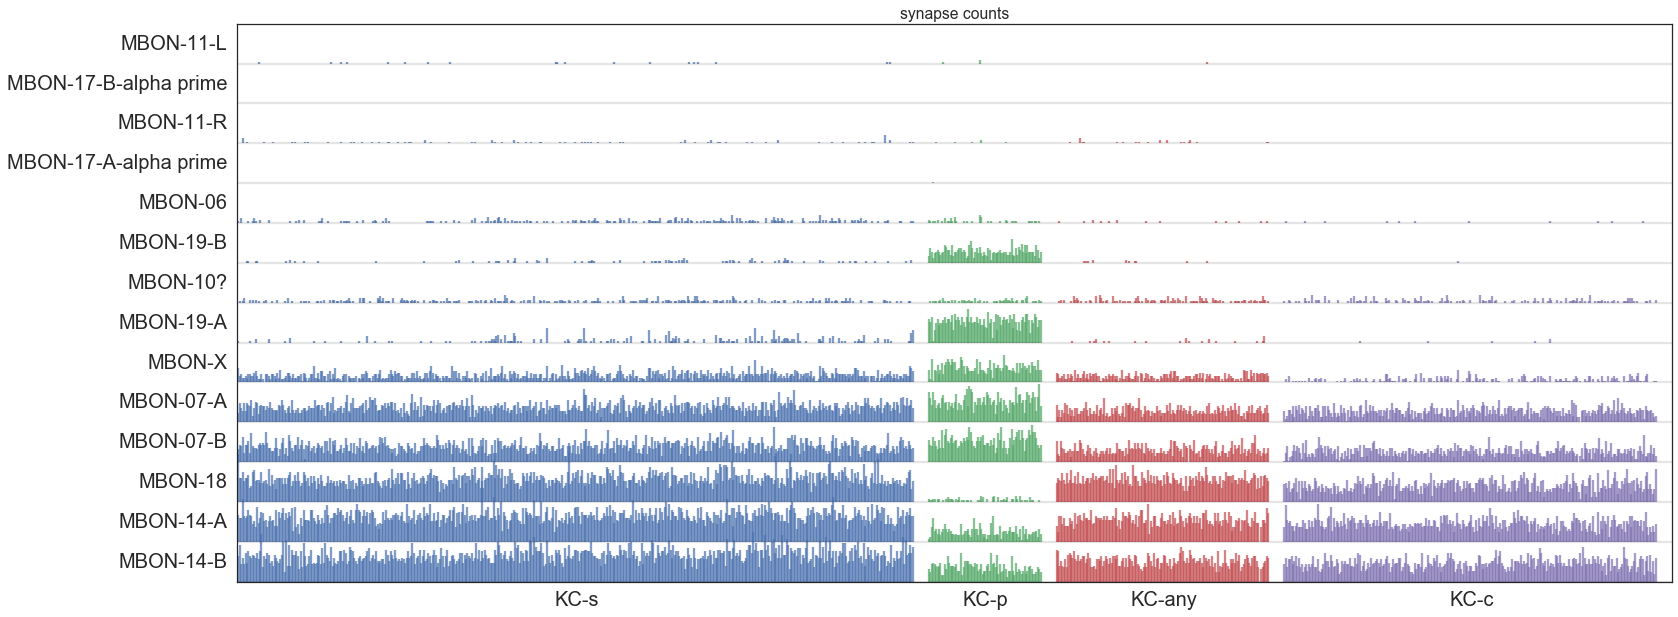

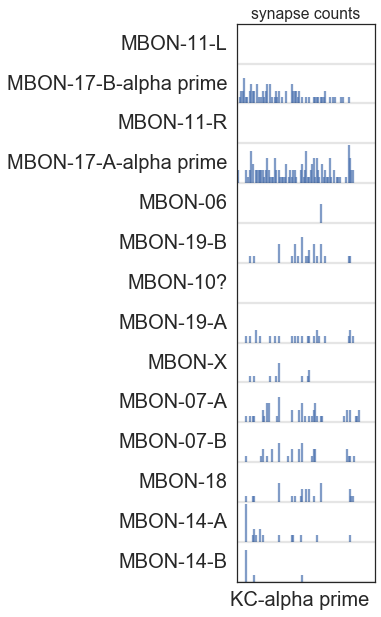

In [16]:
# KC/MBON connectivity:
from matplotlib.collections import LineCollection

cell_groups = [(['KC-s', 'KC-p', 'KC-any', 'KC-c'], 1.0), 
                            (['KC-alpha prime'], 4.0), 
                            (['PAM', 'PPL', 'MBON'], 0.2)]

for group_i, (group_names, scale) in enumerate(cell_groups):

    palette = sns.color_palette("deep", len(group_names))
    running_pos = 0

    vheight = 25.0/scale
    mbon_positions = {n : v*vheight for v, n in enumerate(MBON_ORDER)}

    lines_by_group = {}
    group_centers= {}

    for g in group_names:
        lines = []
        a = dfmerged_mbon_post[dfmerged_mbon_post.celltype_pre == g]


        kcmbon = a.pivot_table(index='body ID_pre', columns='body ID_post', 
                                                       values='id', aggfunc=lambda x : len(x))
        for kpos, (ri, r), in enumerate(kcmbon.iterrows()):
            for mpos, (mi, ri) in enumerate(r.iteritems()):
                mbon_pos = mbon_positions[MBON_neurons.ix[mi].name_clean]
                if np.isfinite(ri):
                    lines.append([(running_pos, mbon_pos), (running_pos, mbon_pos+ri)])
            running_pos += 1
        group_centers[g] = running_pos - len(kcmbon)/2
        running_pos += 10
        lines_by_group[g] = lines


    fig_width = 26 * running_pos/1000.0
    print running_pos, fig_width
    
    fig = pylab.figure(figsize=(fig_width,  10))
    ax = fig.add_subplot(1, 1, 1)

    for p in [mbon_positions[n] for n in MBON_ORDER]:
        ax.axhline(p, c='k', alpha=0.1)

    xticks = []
    for gi, g in enumerate(group_names):
        if len(lines_by_group[g]) > 0:
            line_segments = LineCollection(lines_by_group[g], color=palette[gi], alpha=0.7)
            ax.add_collection(line_segments)
        xticks.append(group_centers[g])
    ax.set_yticks(np.array([mbon_positions[n] for n in MBON_ORDER]) + vheight/2.0)
    ax.set_yticklabels(MBON_ORDER, fontsize=20)
    ax.set_xticks(xticks)
    if scale == 0.2:
        rotation = 90
    else:
        rotation = 0
    ax.set_xticklabels(group_names, fontsize=20, rotation=rotation)
    ax.set_xlim(0, running_pos)
    ax.set_ylim(0, 350.0/scale)
    ax.grid(False)
    ax.set_title("synapse counts")
    #fig.savefig("MBON rosette datascience.kc_syn_by_mbon.pdf")
    fig.savefig("MBON rosette datascience.pre_type_hist.{:d}.pdf".format(group_i))

# rosettes

In [17]:
#warning takes a long time, ~8min
rosette_res = []
MAX_DIST = 200
pos = 0
for ni, n in MBON_neurons.iterrows():
    for convergent in [False, True]:
        if convergent:
            kcs_pre_df = dfmerged_mbon_post[(dfmerged_mbon_post['convergent'] )]
        else:
            kcs_pre_df = dfmerged_mbon_post

        mbons_post = kcs_pre_df[(kcs_pre_df['body ID_post'] == ni) ].copy()

        postsyn_vector = np.zeros((len(mbons_post), 3))
        postsyn_vector[:, 0] = mbons_post.loc_x_post
        postsyn_vector[:, 1] = mbons_post.loc_y_post
        postsyn_vector[:, 2] = mbons_post.loc_z_post
        
        dists = sklearn.metrics.pairwise.euclidean_distances(postsyn_vector)
        idx = np.triu_indices(dists.shape[0], 1)
        dflat = dists[idx]
        dflat = dflat[dflat < MAX_DIST]

        dist_df = pd.DataFrame({'dists' : dflat, 'mbon': n.name_clean, 'body ID_post': ni,
                                'convergent_only': convergent, 'shuffle' : False})
        rosette_res.append(dist_df)
        
        # shuffle
        postsyn_vector_shuffle = postsyn_vector.copy()
        for i in range(3):
            postsyn_vector_shuffle[:, i] = np.random.permutation(postsyn_vector_shuffle[:, i])
        dists = sklearn.metrics.pairwise.euclidean_distances(postsyn_vector_shuffle)
        idx = np.triu_indices(dists.shape[0], 1)
        dflat = dists[idx]
        dflat = dflat[dflat < MAX_DIST]

        dist_df = pd.DataFrame({'dists' : dflat, 'mbon': n.name_clean, 'body ID_post': ni,
                                'convergent_only': convergent, 'shuffle': True})
        rosette_res.append(dist_df)
        
        
        
    pos +=1


In [18]:
alldist_df = pd.concat(rosette_res)

In [19]:
alldist_df[~alldist_df.shuffle].groupby(['mbon', 'convergent_only']).size()

mbon                   convergent_only
MBON-06                False                 970
                       True                  366
MBON-07-A              False              117271
                       True                81689
MBON-07-B              False              119750
                       True                81667
MBON-10?               False                9467
                       True                 6401
MBON-11-L              False                  16
                       True                    4
MBON-11-R              False                 201
                       True                   84
MBON-14-A              False              282871
                       True               224088
MBON-14-B              False              295939
                       True               235864
MBON-17-A-alpha prime  False                 799
                       True                  558
MBON-17-B-alpha prime  False                 231
                       True   

In [20]:
sns.distplot(alldist_df[alldist_df.shuffle].dists, label='shuffled', norm_hist=False)
sns.distplot(alldist_df[~alldist_df.shuffle].dists, label='true', norm_hist=False)
pylab.xlabel('distance')
pylab.ylabel('fraction')
pylab.title("MBON's inter-synapse distances")
pylab.xlim(0, 200)
pylab.legend()
fig.savefig("MBON rosette datascience.hist_distance_all.pdf")

In [21]:
a = alldist_df[alldist_df.convergent_only]
sns.distplot(a[a.shuffle].dists, label='shuffled', norm_hist=False)
sns.distplot(a[~a.shuffle].dists, label='true', norm_hist=False)
pylab.xlabel('distance')
pylab.ylabel('fraction')
pylab.title("MBON's inter-synapse distances, only convergent")
pylab.xlim(0, 200)
pylab.legend()
fig.savefig("MBON rosette datascience.hist_distance_only_convergent.pdf")

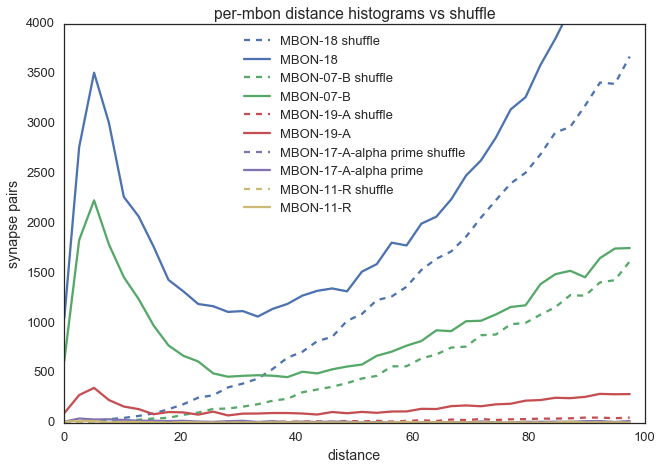

In [22]:
mbon_names_by_size = alldist_df.mbon.value_counts().index.values
fig = pylab.figure()
ax = fig.add_subplot(1, 1, 1)
alldist_df_lt = alldist_df[alldist_df.dists<100]
bins=np.linspace(0, 100, 40)
for i, mbon_id in enumerate(mbon_names_by_size[::3]):
    d = alldist_df_lt[alldist_df_lt.mbon == mbon_id]
    ds = d[d.shuffle]
    hist, edgs = np.histogram(ds.dists, bins=bins)
    ax.plot(edgs[:-1], hist, color=current_palette[i], linestyle='--', 
                label='%s shuffle' % mbon_id)
    
    dns = d[~d.shuffle]

    hist, edgs = np.histogram(dns.dists, bins=bins)
    ax.plot(edgs[:-1], hist, color=current_palette[i], label='%s' % mbon_id)
pylab.legend(loc='upper center')
ax.set_title("per-mbon distance histograms vs shuffle")
ax.set_ylabel('synapse pairs')
ax.set_xlabel('distance')
ax.grid(False)
ax.set_ylim(0, 4000)
fig.savefig("MBON rosette datascience.per-mbon distance histograms vs shuffle.pdf")

# precomputed rosette analysis

Using the python preprocessing script 

In [23]:
all_mbon_rosettes = pickle.load(open("../data/mushroombody.all-MBON.rosette.df.pickle", 'r'))
rosette_df = all_mbon_rosettes['rosette_df']


### How many unique presynaptic cells participate in a rosette

What are the sizes of subsets, and how do they vary? 

In [79]:
convergent_filtered = False
ROSETTE_THRESHOLD = 40
rosettes_th = rosette_df[(rosette_df.rosette_thold == ROSETTE_THRESHOLD) \
                         & (rosette_df.convergent_filtered == convergent_filtered)]
sizes_vs_counts = rosettes_th.groupby(['rosette_id'])\
.agg({'rosette_id' : 'size', 'body ID_pre': pd.Series.nunique}) \
.rename(columns = {'rosette_id' : 'synapse_count', 'body ID_pre' : "unique_synapse_count"})

In [80]:
sizes_vs_counts.groupby(['synapse_count', 'unique_synapse_count']).size()

synapse_count  unique_synapse_count
1              1                       6445
2              1                        151
               2                       8038
3              1                          4
               2                        330
               3                       5056
4              2                         40
               3                        567
               4                       2808
5              2                          4
               3                         66
               4                        485
               5                       1157
6              3                          9
               4                         74
               5                        311
               6                        432
7              3                          4
               4                         20
               5                         81
               6                        160
               7                        

In [ ]:
rosette

In [24]:
ROSETTE_THRESHOLD = 40
pre_ids_unique = np.intersect1d(np.unique(rosette_df['body ID_pre']), neurons_df['body ID'])
pre_ids_to_pos = {k:v for v, k in enumerate(pre_ids_unique)}
PREN = len(pre_ids_unique)

pre_ids_names = []

for pi in pre_ids_unique:
    a = neurons_df[neurons_df['body ID'] == pi].iloc[0]
    pre_ids_names.append(a['name'])
pre_ids_names = np.array(pre_ids_names)
rand_idx = np.argsort(pre_ids_names)# np.random.permutation(KCN)
pre_ids_names_sorted = pre_ids_names[rand_idx]

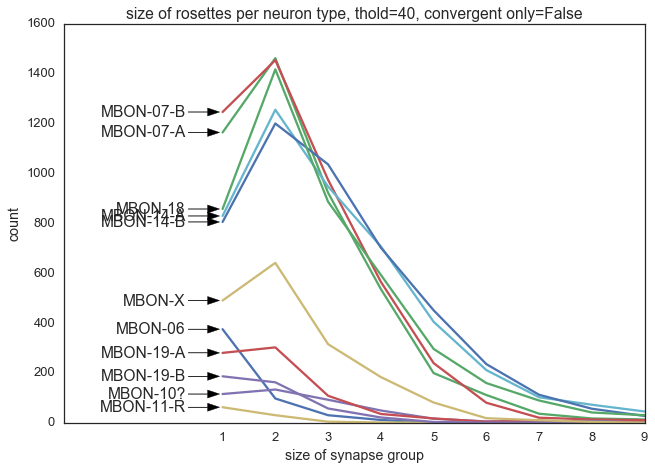

In [44]:
convergent_filtered = False
for ROSETTE_THRESHOLD in [20, 40]:
    rosettes_th = rosette_df[(rosette_df.rosette_thold == ROSETTE_THRESHOLD) \
                             & (rosette_df.convergent_filtered == convergent_filtered)]
    #rosettes_th = rosettes_th[rosettes_th['body ID_pre'].isin(pre_ids_unique)]

    fig = pylab.figure()
    ax = fig.add_subplot(1, 1,1)
    bins = np.arange(10) + 1

    annotations = []

    for gi, g in rosettes_th.groupby('post_name'):
        h, _ = np.histogram(g.rosette.value_counts(), bins)
        if h[0] > 40:
            ax.plot(bins[:-1], h, label=gi)
            annotations.append(ax.annotate(gi, xy=(0.95, h[0]), xytext=(0.3, h[0]), 
                                     horizontalalignment='right',
                                     verticalalignment='center', 
                                     arrowprops=dict(facecolor='black', shrink=0.01,
                                                     width=0.2, headwidth=8.0),))
        else:
            ax.plot(0, 0, label=gi, c='k', linestyle='--')
        #ax.scatter(bins[:-1], h, c='k')


    for a in annotations:
        pass
    ax.set_xticks(bins[:-1])
    ax.grid(False)
    ax.set_xlabel("size of synapse group")
    ax.set_ylabel('count')
    ax.set_title("size of rosettes per neuron type, thold={:d}, convergent only={}".format(ROSETTE_THRESHOLD, 
                                                                                      convergent_filtered))
    ax.set_xlim(-2, np.max(bins)-1)
    
    fig.savefig("MBON rosette datascience.size of rosettes per neuron type.{:d}.pdf".format(ROSETTE_THRESHOLD))

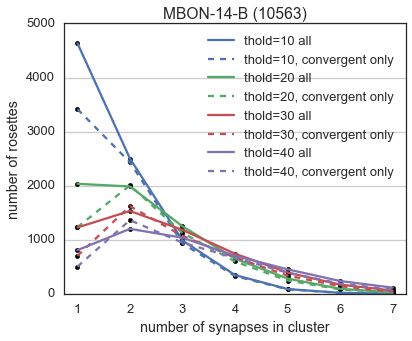

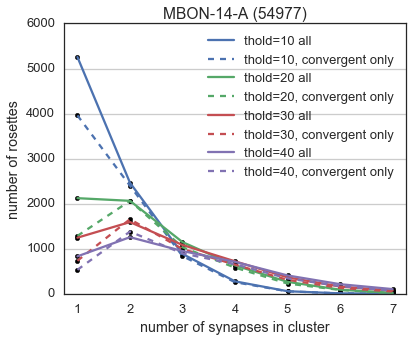

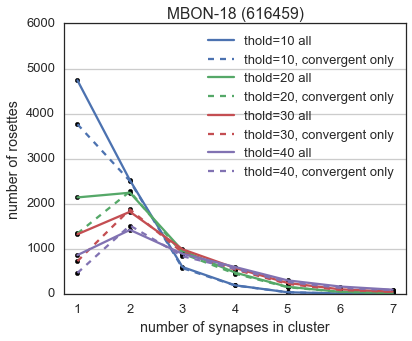

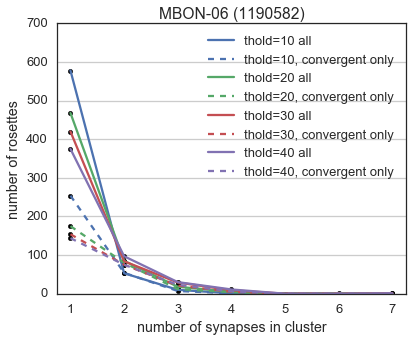

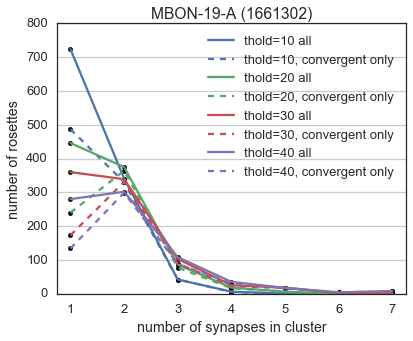

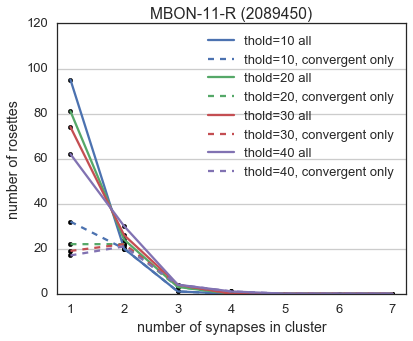

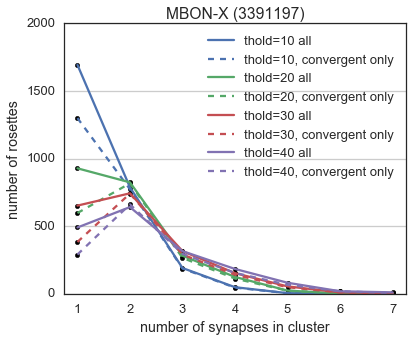

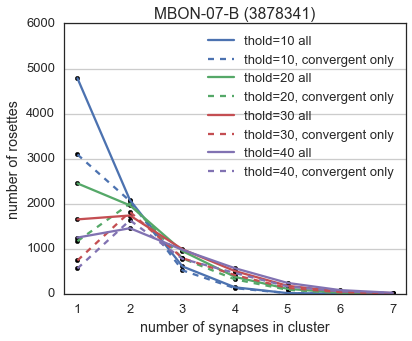

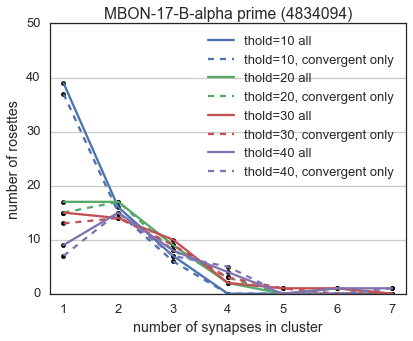

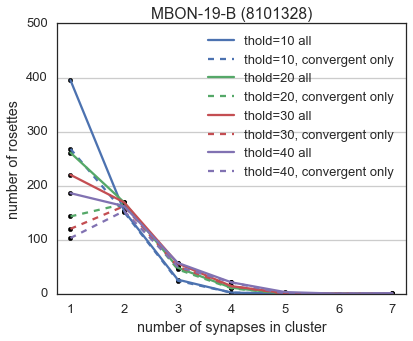

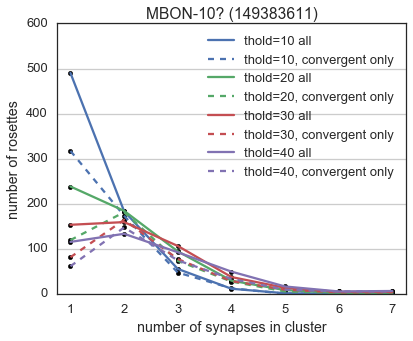

In [45]:
current_palette = sns.color_palette()
thold_index = {k: v for v, k in enumerate(np.sort(np.unique(rosette_df.rosette_thold)))}

bins = np.linspace(0, 7, 8) + 0.5

for mbon_id, mbon_rosettes in rosette_df.groupby('body ID_post'):
    fig = pylab.figure(figsize=(6, 5))
    ax = fig.add_subplot(1, 1, 1)
    mbon_name = neuronsdf.ix[mbon_id].name_clean
    for (thold, convergent_filtered), atthold in mbon_rosettes \
                .groupby(['rosette_thold', 'convergent_filtered']):
        h, _ = np.histogram(atthold.rosette_id.value_counts(), bins)
        linestyle = "-"
        label = label = "thold={:d} all".format(thold)
        if convergent_filtered:
            linestyle = '--'
            label = "thold={:d}, convergent only".format(thold)
        ax.plot(bins[1:]-0.5, h, c= current_palette[thold_index[thold]], 
                linestyle=linestyle, label=label)
        ax.scatter(bins[1:]-0.5, h, c='k', edgecolor='k')
        #ax.text( 0.9, h[0],"thold={}".format(thold), horizontalalignment='right')
        #ax.plot(bins, kde(bins)*100000)
    ax.set_title("{} ({})".format(mbon_name, mbon_id))
    ax.set_xticks(range(1, 11))
    ax.set_xlim(0.75, 7.25)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("number of synapses in cluster")
    ax.set_ylabel("number of rosettes")
    ax.yaxis.grid(True)
    pylab.legend()
    fig.tight_layout()
    fig.savefig("MBON rosette datascience.rosettes_vs_thold.{:s}.pdf".format(mbon_name))

In [27]:
pre_rosette_pre_mats = {}
pre_pre_mats = {}
MAX_ROSETTE_SIZE = 25
ROSETTE_THOLD = 40
rosettes_th = rosette_df[(rosette_df.rosette_thold == ROSETTE_THRESHOLD) & (~rosette_df.convergent_filtered)]
rosettes_th = rosettes_th[rosettes_th['body ID_pre'].isin(pre_ids_unique)]
    
for post_name, a in  rosettes_th.groupby('post_name'):


    conn_mat = np.zeros((PREN, PREN, MAX_ROSETTE_SIZE), dtype=np.uint16)

    for rosette_id, rosette in a.groupby('rosette_id'):
        pre_ids = np.unique(rosette['body ID_pre'])
        pos = [pre_ids_to_pos[pre_id] for pre_id in pre_ids]
        #if len(rosette) > 1
        rosette_size = len(rosette)
        for i in pos:
            for j in pos:
                if i != j: # ignore same-same
                    conn_mat[i, j, rosette_size] += 1 
    pre_rosette_pre_mats[post_name] = conn_mat
    
    # now kc-kc ignoring rosette
    pre_pre_conn_mat = np.zeros((PREN, PREN))
    allpos = [pre_ids_to_pos[i] for i in a['body ID_pre'].value_counts().index.values]
    for i in allpos:
        for j in allpos:
            pre_pre_conn_mat[i, j] = 1
    pre_pre_mats[post_name] = pre_pre_conn_mat
    

In [28]:
res = []
for mbon_name in pre_rosette_pre_mats.keys():

    #fig = pylab.figure(figsize=(20, 20))
    #ax = fig.add_subplot(1, 1, 1)

    rosette_mat = pre_rosette_pre_mats[mbon_name]
    conn_mat = rosette_mat[:, :, 2:].sum(axis=2)
    
    for i, v in pd.value_counts(conn_mat.flatten()).iteritems():
        res.append({'mbon_name' : mbon_name, 'rosette_num' : i, 'conn_pairs' : v})
    

In [29]:
counts_by_mbon = pd.DataFrame(res)
counts_by_mbon_sorted = counts_by_mbon[counts_by_mbon.rosette_num > 0].groupby('mbon_name')\
    .agg({'conn_pairs': 'sum'}).sort_values('conn_pairs', ascending=False)

In [30]:
pt = counts_by_mbon.pivot(index='mbon_name', columns='rosette_num', values='conn_pairs').fillna(0)
pt = pt.sort_values(0)


In [31]:
pt

rosette_num                    0        1       2      3     4     5    6    7
mbon_name                                                                     
MBON-14-A              1374104.0  29048.0  3010.0  390.0  34.0   8.0  2.0  0.0
MBON-14-B              1374284.0  28780.0  3056.0  434.0  34.0   6.0  0.0  2.0
MBON-18                1381794.0  21566.0  2792.0  364.0  68.0  10.0  2.0  0.0
MBON-07-B              1390908.0  14720.0   892.0   68.0   8.0   0.0  0.0  0.0
MBON-07-A              1390948.0  14808.0   768.0   68.0   2.0   2.0  0.0  0.0
MBON-X                 1400116.0   6148.0   306.0   24.0   2.0   0.0  0.0  0.0
MBON-19-A              1404826.0   1568.0   180.0   20.0   2.0   0.0  0.0  0.0
MBON-10?               1405052.0   1528.0    16.0    0.0   0.0   0.0  0.0  0.0
MBON-19-B              1405782.0    774.0    38.0    2.0   0.0   0.0  0.0  0.0
MBON-06                1406128.0    456.0    10.0    0.0   0.0   0.0  0.0  2.0
MBON-17-A-alpha prime  1406280.0    292.0    22.0    2.0   0.0   0.0  0.0  0.0
MBON-17-B-alpha prime  1406448.0    146.0     2.0    0.0   0.0   0.0  0.0  0.0
MBON-11-R              1406514.0     80.0     2.0    0.0   0.0   0.0  0.0  0.0
MBON-11-L              1406586.0     10.0     0.0    0.0   0.0   0.0  0.0  0.0

In [32]:
current_palette = sns.color_palette()
fig = pylab.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ind = np.arange(len(pt))
width = 0.75
legend_handles = []

for i in range(1, 5):
    b = {}
    if i > 1:
        b = {'bottom' : np.sum([np.array(pt[j]) for j in range(1, i)], axis=0)}
    if i < 4:
        p = pt[i]
        label = i
    else:
        p = np.sum([pt[j] for j in range(4, 8)], axis=0)
        label = ">=4"
        
    p1 = ax.bar(ind, np.array(p), width, color=current_palette[i-1], **b)
    
    legend_handles.append(matplotlib.patches.Patch(color=current_palette[i-1], label=label))
    

ax.set_ylabel('cell-cell pairs')
ax.set_xlabel('MBON')
ax.set_xticks(ind + width/2.0)
print ax.get_xticks()
names = np.array(pt.index.values)

for i in range(len(names)):
    if '-alpha' in names[i]:
        names[i] = names[i].replace("-alpha", "\n-alpha")

ax.set_xticklabels(names, rotation=90)

ax.legend(handles=legend_handles)

ax.grid(0)
ax.set_title("cell-cell pairs connected by  N rosettes")
fig.tight_layout()
ax.set_xlabel("postsynaptic MBON")
ax.set_ylabel("number of cell-cell pairs")
fig.savefig("MBON rosette datascience.cell cell pairs through rosettes.pdf")

[  0.375   1.375   2.375   3.375   4.375   5.375   6.375   7.375   8.375
   9.375  10.375  11.375  12.375  13.375]


In [33]:
# is there a correlation between counts across cell types
mbon_order =  pre_rosette_pre_mats.keys()
count_mats = []
res = []
for mbon_name in MBON_ORDER:
    rosette_mat = pre_rosette_pre_mats[mbon_name]
    count_mats.append( rosette_mat[:, :, 2:].sum(axis=2))
count_mats = np.array(count_mats)
count_sum = count_mats.sum(axis=0)

In [34]:
count_std = count_mats.std(axis=0)
count_mean = count_mats.mean(axis=0)

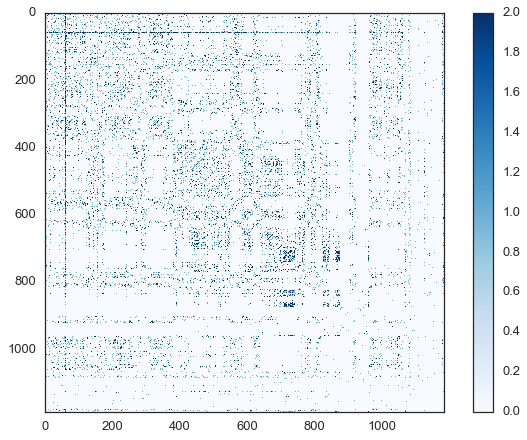

In [35]:
pylab.imshow(count_sum, vmin=0, vmax=2, interpolation='nearest', cmap=pylab.cm.Blues)
pylab.colorbar()

32492


NameError: name 'KCN' is not defined

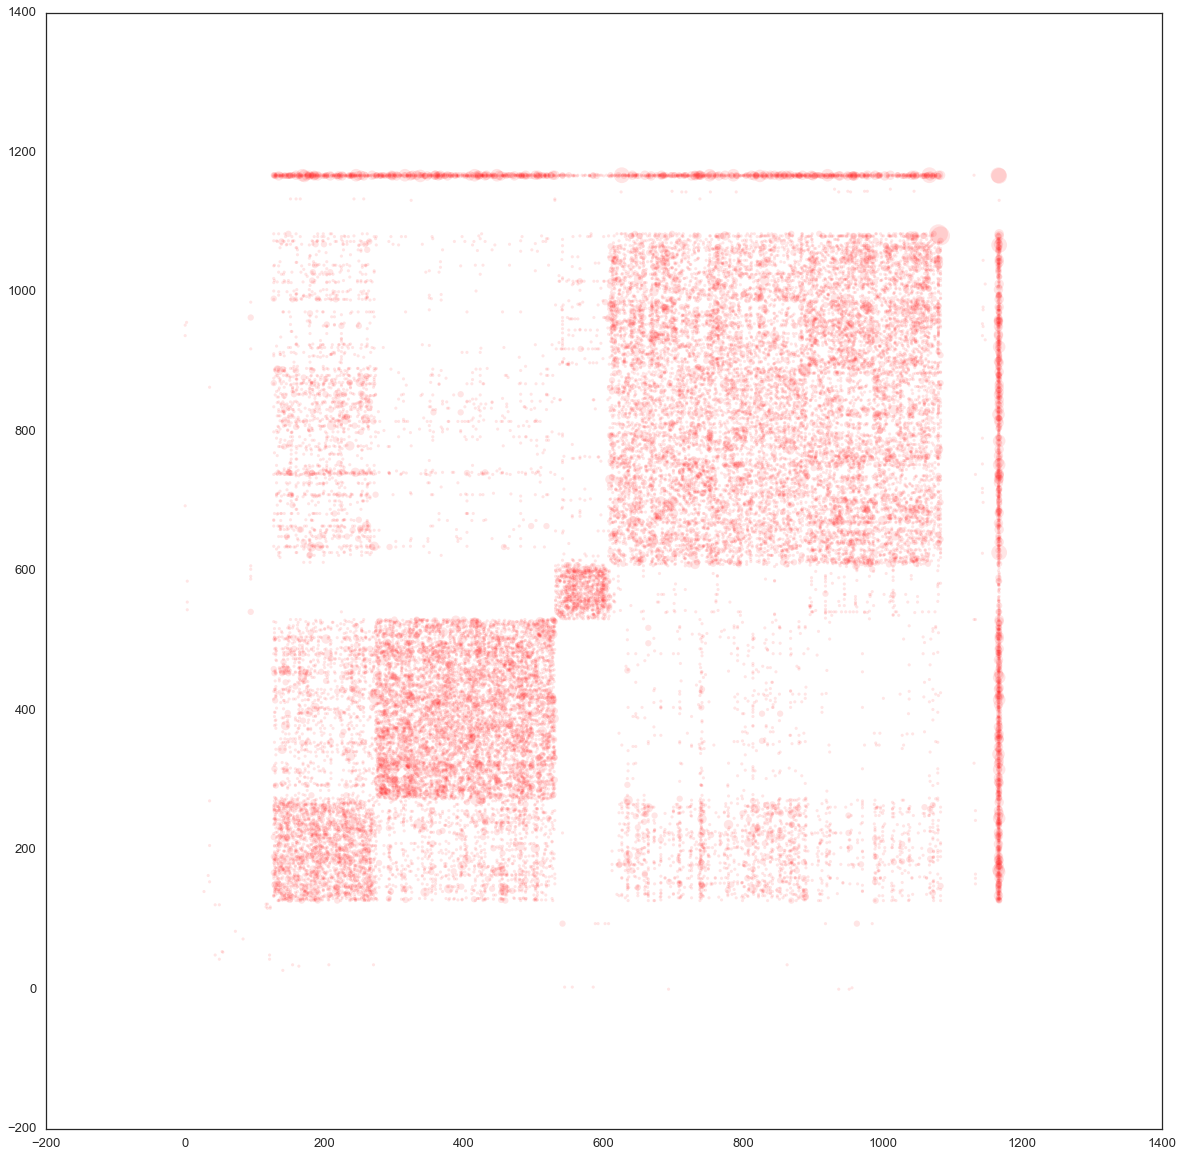

In [36]:
for mbon_name in pre_rosette_pre_mats.keys():

    fig = pylab.figure(figsize=(20, 20))
    ax = fig.add_subplot(1, 1, 1)

    rosette_mat = pre_rosette_pre_mats[mbon_name]
    conn_mat = rosette_mat[:, :, 2:].sum(axis=2)
    
    
    pre_pre_mat =pre_pre_mats[mbon_name]
    conn_rand = conn_mat[rand_idx]
    conn_rand = conn_rand[:, rand_idx]
    
    pre_pre_sorted = pre_pre_mat[rand_idx]
    pre_pre_sorted = pre_pre_sorted[:, rand_idx]
    
    
    a = np.argwhere(conn_rand)
    print len(a)
    counts = np.array([conn_rand[i, j] for i, j in a])
    ax.scatter(a[:, 0], a[:, 1], edgecolor='none', c='r',
               s=10*counts**2, alpha=0.1)
    ax.set_xlim(0, KCN)
    ax.set_ylim(KCN, 0)
    
    im = np.ones((pre_pre_sorted.shape[0], pre_pre_sorted.shape[1], 4))
    im[:, :, 2] = 1-pre_pre_sorted
    im[:, :, 0] = 1-pre_pre_sorted
    im[:, :, 1] = 1-pre_pre_sorted
    im[:, :, 3] = pre_pre_sorted * 0.05
    ax.imshow(im)
    ticks = np.arange(0, len(pre_ids_names), 10)
    ax.set_yticks(ticks)
    ax.set_yticklabels(pre_ids_names_sorted[ticks])
    ax.set_xticks(ticks)
    ax.set_xticklabels(pre_ids_names_sorted[ticks], rotation=90)
    #ax.set_yticks([])
    ax.set_title(mbon_name)
    ax.grid(False)
    ax.set_xlabel("pre cell ID")
    ax.set_ylabel("pre cell ID")
    fig.savefig("pre-rosette-pre %s.png" % mbon_name, dpi=300)
    break

# More careful rosette analysis examining converged synapses

In [ ]:
fig = pylab.figure(figsize=(3, 3))
sns.kdeplot(dfmerged_mbon_post.loc_x_pre- dfmerged_mbon_post.loc_x_post, label='x-delta')  
sns.kdeplot(dfmerged_mbon_post.loc_y_pre- dfmerged_mbon_post.loc_y_post, label='y-delta')  
#sns.kdeplot(dfmerged_mbon_post.loc_z_pre- dfmerged_mbon_post.loc_z_post)  
pylab.legend()

fig = pylab.figure(figsize=(3, 3))
sns.kdeplot(dfmerged_mbon_post.loc_z_pre- dfmerged_mbon_post.loc_z_post, label='z-delta')  
#sns.kdeplot(dfmerged_mbon_post.loc_z_pre- dfmerged_mbon_post.loc_z_post)  
pylab.legend()


In [ ]:
#warning takes a long time
rosette_res = []
MAX_DIST = 140
pos = 0
for ni, n in MBON_neurons.iterrows():
    #if '14' not in n.name_clean:
    #    continue # DEBUG
    kcs_pre_df = dfmerged_mbon_post

    mbons_post = kcs_pre_df[(kcs_pre_df['body ID_post'] == ni) ].copy()

    # post-synaptic distance matrix
    postsyn_vector = np.zeros((len(mbons_post), 3))
    postsyn_vector[:, 0] = mbons_post.loc_x_post
    postsyn_vector[:, 1] = mbons_post.loc_y_post
    postsyn_vector[:, 2] = mbons_post.loc_z_post
    
    post_dists = sklearn.metrics.pairwise.euclidean_distances(postsyn_vector)
    
    # pre-synaptic distance matrix
    presyn_vector = np.zeros((len(mbons_post), 3))
    presyn_vector[:, 0] = mbons_post.loc_x_pre
    presyn_vector[:, 1] = mbons_post.loc_y_pre
    presyn_vector[:, 2] = mbons_post.loc_z_pre
    
    pre_dists = sklearn.metrics.pairwise.euclidean_distances(presyn_vector)
    
    # generate a matrix with the same shape as the distance matrix
    # telling us which synapses are being measured
    tbar_id_mat = np.array(np.meshgrid(mbons_post['tbar_id'], mbons_post['tbar_id']))
    tbar_id_mat = np.swapaxes(tbar_id_mat, 0, 2)
    
    idx = np.triu_indices(pre_dists.shape[0], 1)
    post_dflat = post_dists[idx]
    pre_dflat = pre_dists[idx]
    tbar_ids = tbar_id_mat[idx]

    # just select far-away subset:
    closer_idx = (pre_dflat < MAX_DIST) | (post_dflat < MAX_DIST)
    post_dflat = post_dflat[closer_idx]
    pre_dflat = pre_dflat[closer_idx]
    tbar_ids = tbar_ids[closer_idx]

    dist_df = pd.DataFrame({'pre_dist' : pre_dflat, 
                            'post_dist' : post_dflat, 
                            'tbar_id_1' : tbar_ids[:, 0], 
                            'tbar_id_2' : tbar_ids[:, 1],
                            'mbon': n.name_clean, 'body ID_post': ni})
    rosette_res.append(dist_df)

    pos +=1
    


In [ ]:
alldist_df = pd.concat(rosette_res)
len(alldist_df)

In [ ]:
    ng = sklearn.neighbors.radius_neighbors_graph(postsyn_vector, thold, include_self=True)
    cc = scipy.sparse.csgraph.connected_components(ng)[1]

In [ ]:
tbar_convergent_df = tbar_df[['id', 'convergent']].copy()
tbar_convergent_df.convergent = (tbar_convergent_df.convergent == "convergent")
tbar_convergent_df = tbar_convergent_df.set_index('id')
a = alldist_df.join(tbar_convergent_df, on='tbar_id_1', )
a = a.rename(columns={"convergent" : "convergent_1"})
b = a.join(tbar_convergent_df, on='tbar_id_2', )
b = b.rename(columns={"convergent" : "convergent_2"})
alldist_df = b

In [ ]:
sns.jointplot(alldist_df.pre_dist, alldist_df.post_dist, xlim=(0, 100), ylim=(0, 100), kind="hex")

In [ ]:
dist_bins = np.linspace(0, MAX_DIST, 60)
sns.distplot(alldist_df.pre_dist, label="presyn distance", bins=dist_bins, kde=False)
sns.distplot(alldist_df.post_dist, label='postsyn distance', bins=dist_bins, kde=False)

#sns.distplot(alldist_df[~alldist_df.shuffle].dists, label='true', norm_hist=False)
pylab.xlabel('distance')
pylab.ylabel('fraction')
pylab.title("histogram of inter-synapse distances on a MBON for all tbars")
pylab.xlim(0, MAX_DIST)
pylab.legend(loc='upper left')

In [ ]:
one_non_conv_df = alldist_df[(alldist_df.convergent_1 == False) | (alldist_df.convergent_2 == False)]
sns.distplot(one_non_conv_df.pre_dist, label="presyn distance", bins =dist_bins, kde=False)
sns.distplot(one_non_conv_df.post_dist, label='postsyn distance', bins=dist_bins, kde=False)

#sns.distplot(alldist_df[~alldist_df.shuffle].dists, label='true', norm_hist=False)
pylab.xlabel('distance')
pylab.ylabel('fraction')
pylab.title("histogram of inter-synapse distances on a MBON for all non-convergent tbars")
pylab.xlim(0, MAX_DIST)
pylab.legend(loc='upper left')

In [ ]:
sns.jointplot(one_non_conv_df.pre_dist, one_non_conv_df.post_dist, 
              xlim=(0, 100), ylim=(0, 100), kind="hex")
pylab.title("pre-post distances where one \nsynapse has a non-convergent tbar")

# investigate all synaptic spatial localization on MBON

Not just KC

In [ ]:
dfmerged_mbon_post = dfmerged[dfmerged['body ID_post'].isin(MBON_neurons.index.values)].copy()
#MBON_neurons = neuronsdf[neuronsdf.name_clean.str[:4] == 'MBON']
TGT_MBON = 'MBON-07-A'
tgt_mbon_rec = MBON_neurons[MBON_neurons.name_clean == TGT_MBON].iloc[0]
tgt_mbon_post_df = dfmerged_mbon_post[dfmerged_mbon_post['body ID_post'] == tgt_mbon_rec.name].copy()
# counts

names_df = neuronsdf[['name_clean']]
tgt_mbon_post_df = tgt_mbon_post_df.join(names_df, on='body ID_pre')\
                        .rename(columns={'name_clean' : 'name_clean_pre'})
    
    
a = tgt_mbon_post_df.groupby(['body ID_pre']).agg({'body ID_pre' : 'count', 'name_clean_pre' : 'first'})
b = a.sort_values('body ID_pre', ascending=False)


In [ ]:
print "for cell {} how many of cell type x syanpse onto it, and how many times?".format(TGT_MBON)
print b.dtypes

# THIS IS A HACK TO CLUSTER PAM AS A CELL TYPE
c = b.name_clean_pre.apply(lambda x :'PAM' if 'PAM-' in str(x) else x)
b['name_pre_summary'] = c
b.groupby('name_pre_summary').agg({'body ID_pre': ['count', 'mean', 'std', 'sum']})\
        .sort_values(('body ID_pre', 'sum'), ascending=False)

In [ ]:
# ok just for each MBON compute the distances between synapses using the 
#  identified by tbar ID

#warning takes a long time
rosette_res = []
MAX_DIST = 140
pos = 0
for mbon_body_id, mbons_post in dfmerged_mbon_post.groupby('body ID_post'):
    print "solving for MBON id=", mbon_body_id, len(mbons_post), "connections"
    # post-synaptic distance matrix
    postsyn_vector = np.zeros((len(mbons_post), 3))
    postsyn_vector[:, 0] = mbons_post.loc_x_post
    postsyn_vector[:, 1] = mbons_post.loc_y_post
    postsyn_vector[:, 2] = mbons_post.loc_z_post
    
    post_dists = sklearn.metrics.pairwise.euclidean_distances(postsyn_vector)
    
    # pre-synaptic distance matrix
    presyn_vector = np.zeros((len(mbons_post), 3))
    presyn_vector[:, 0] = mbons_post.loc_x_pre
    presyn_vector[:, 1] = mbons_post.loc_y_pre
    presyn_vector[:, 2] = mbons_post.loc_z_pre
    
    pre_dists = sklearn.metrics.pairwise.euclidean_distances(presyn_vector)
    
    # generate a matrix with the same shape as the distance matrix
    # telling us which synapses are being measured
    tbar_id_mat = np.array(np.meshgrid(mbons_post['tbar_id'], mbons_post['tbar_id']))
    tbar_id_mat = np.swapaxes(tbar_id_mat, 0, 2)
    
    idx = np.triu_indices(pre_dists.shape[0], 1)
    post_dflat = post_dists[idx]
    pre_dflat = pre_dists[idx]
    tbar_ids = tbar_id_mat[idx]

    # just select far-away subset:
    closer_idx = (pre_dflat < MAX_DIST) | (post_dflat < MAX_DIST)
    post_dflat = post_dflat[closer_idx]
    pre_dflat = pre_dflat[closer_idx]
    tbar_ids = tbar_ids[closer_idx]

    dist_df = pd.DataFrame({'pre_dist' : pre_dflat, 
                            'post_dist' : post_dflat, 
                            'tbar_id_1' : tbar_ids[:, 0], 
                            'tbar_id_2' : tbar_ids[:, 1],
                            'body ID_post': mbon_body_id})
    rosette_res.append(dist_df)

    ng = sklearn.neighbors.radius_neighbors_graph(postsyn_vector,
                                                  thold, 
                                                  include_self=True)
    cc = scipy.sparse.csgraph.connected_components(ng)[1]
    
    
    pos +=1
    


In [ ]:
df = pd.concat(rosette_res)
a = df.join(tbar_df[['body ID']], on='tbar_id_1').rename(columns={'body ID' : "body ID_1"})

df = a.join(tbar_df[['body ID']], on='tbar_id_2').rename(columns={'body ID' : "body ID_2"})


In [ ]:
cell_types_df = neuronsdf.copy()
cell_types_df['cell_type']= cell_types_df.name_clean

cell_types_df.loc[cell_types_df.name_clean.str.contains("PAM-"), 'cell_type'] = 'PAM'
#cell_types_df.loc[cell_types_df.name_clean.str.contains("PAM-"), 'cell_type'] = 'PAM'
# maybe we should clean some of these up? Oh well. 


df = df.join(cell_types_df[['cell_type']], on="body ID_1")\
    .rename(columns={"cell_type" : "cell_type_1"})
df = df.join(cell_types_df[['cell_type']], on="body ID_2")\
    .rename(columns={"cell_type" : "cell_type_2"})
df.head()

In [ ]:
# this is a cleanup -- we want cell_type_1 <= cell_type_2 so that we don't count 
# (A, B) differently from (B, A). SLOW ~3 min

def canonicalize_type(row):
    row = row.copy()
    if row.cell_type_1 > row.cell_type_2:
        ct2 = row.cell_type_2
        row.cell_type_2 = row.cell_type_1
        row.cell_type_1 = ct2
        row.tbar_id_1, row.tbar_id_2 = row.tbar_id_2, row.tbar_id_1
        row['body ID_1'], row['body ID_2'] = row['body ID_2'], row['body ID_1']
    return row
a =df.apply(canonicalize_type, axis=1)
#print a
#print canonicalize_type(a)
a.head()

In [ ]:
#### 
from sklearn.neighbors import KernelDensity

tgt_mbon_id = 10563
mbon_pre_dists = a[a['body ID_post'] == tgt_mbon_id]

biggest_cell_types = mbon_pre_dists.cell_type_1.value_counts()[:8].index.values.tolist()
biggest_cell_types.remove("")

tgt_dists = mbon_pre_dists[(mbon_pre_dists.cell_type_1.isin(biggest_cell_types) & mbon_pre_dists.cell_type_2.isin(biggest_cell_types))]
order = np.sort(tgt_dists.cell_type_1.value_counts().index.values)

# now we par them down 
import matplotlib.gridspec as gridspec


fig = pylab.figure(figsize=(16, 16))

gs = gridspec.GridSpec(len(order), len(order))
pos_lut = {k : v for v, k in enumerate(order)}
bins=np.linspace(0, 80, 20)
for (gi, gf), g in tgt_dists.groupby(['cell_type_1', 'cell_type_2']):
    ax = plt.subplot(gs[pos_lut[gi], pos_lut[gf]])

    if len(g.post_dist) > 100:
       
        #sns.distplot(g.post_dist, bins=bins, kde=False, norm_hist=False)
        pylab.hist(g.post_dist, bins=bins)
        #kde = scipy.stats.gaussian_kde(g.post_dist)

        
        #ax.plot(bins, kde(bins)*100000)
        ax.set_ylim(0,700)

        if pos_lut[gf] == pos_lut[gi]:
            ax.set_ylabel(order[pos_lut[gi]], fontsize=24)
        if pos_lut[gi] == 0:
            ax.set_title(order[pos_lut[gf]], fontsize=24)
        #print pos_lut[gi], pos_lut[gf]
    ax.set_xticks([])
    ax.set_yticks([])    

In [ ]:
kc_ids = np.sort(neuronsdf[neuronsdf.name_clean.str.contains('KC-')].index.values)
N = len(kc_ids)
conductivity = np.zeros((N, N))
k_pos = {k: v for v, k in enumerate(kc_ids)}
a = df[df['body ID_post'] == tgt_mbon_id]
print len(a)
for c_i, c in a.iterrows():
    if (c['body ID_1'] in k_pos) and (c['body ID_2'] in k_pos):
        i, j =  k_pos[c['body ID_1']], k_pos[c['body ID_2']]
        conductivity[i, j] += 1./(c.post_dist + 10)


In [ ]:
s = neuronsdf.ix[kc_ids].name_clean
ai = np.argsort(s)

In [ ]:
c = conductivity[ai]
c = c[:, ai]

pylab.figure(figsize=(12, 12))
pylab.imshow(np.log10(c), vmax=-2.5)  # , cmap=pylab.cm.jet)
pylab.colorbar()

In [ ]:
#for all synapses sites on a mbon, how does rosette size vary with threshold:
    

In [ ]:
tgt_id = 10563
a = all_rosette_df[all_rosette_df['body ID_post'] == tgt_id]
thold = 10
b = a[a.rosette_thold == thold]
zdim = 2900, 3100
xdim = 4000, 4500
ydim = 6000, 6500
c = b[(b.loc_x_post > xdim[0]) & (b.loc_x_post < xdim[1]) & \
     (b.loc_y_post > ydim[0]) & (b.loc_y_post < ydim[1]) &\
     (b.loc_z_post > zdim[0]) & (b.loc_z_post < zdim[1])]

fig =pylab.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1,1 )
ax.scatter(c.loc_x_post, c.loc_y_post, edgecolor='none', c='b', s=30, alpha=1)
ax.scatter(c.loc_x_pre, c.loc_y_pre, edgecolor='none', c='r', s=10)
l = []
for ri, r in c.iterrows():
    l.append([(r.loc_x_pre, r.loc_y_pre), (r.loc_x_post, r.loc_y_post)])
lc = LineCollection(l, color='k')
ax.add_collection(lc)


In [ ]:
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

for mbon_id, mbon_rosettes in all_rosette_df.groupby('body ID_post'):
    mbon_name = neuronsdf.ix[mbon_id].name_clean
    a = mbon_rosettes # all_rosette_df[all_rosette_df['body ID_post'] == tgt_id]
    thold = 20
    b = a[a.rosette_thold == thold]
    zdim = 2700, 3100
    xdim = 4000, 4300
    ydim = 6000, 6300
    c = b[(b.loc_x_post > xdim[0]) & (b.loc_x_post < xdim[1]) & \
         (b.loc_y_post > ydim[0]) & (b.loc_y_post < ydim[1]) &\
         (b.loc_z_post > zdim[0]) & (b.loc_z_post < zdim[1])]



    for coord1, coord2 in [('x', 'y'), ('x', 'z')]:
        fig =pylab.figure(figsize=(20, 20))
        ax = fig.add_subplot(1, 1,1 )

        coord_x_pre = 'loc_{}_pre'.format(coord1)
        coord_y_pre = 'loc_{}_pre'.format(coord2)
        coord_x_post = 'loc_{}_post'.format(coord1)
        coord_y_post = 'loc_{}_post'.format(coord2)

        ax.scatter(c[coord_x_post], c[coord_y_post], 
                   edgecolor='none', c='b', s=50, alpha=0.2)
        ax.scatter(c[coord_x_pre], c[coord_y_pre], 
                   edgecolor='none', c='g', s=50, alpha=0.4)
        ax.quiver(c[coord_x_pre], c[coord_y_pre],
                  c[coord_x_post] - c[coord_x_pre], 
                  c[coord_y_post] - c[coord_y_pre], 
                  scale_units='xy', angles='xy', scale=1, width=0.003, 
                  minlength=0.1, headlength=4, headwidth=4, alpha=0.7) # , headlength=0.1)
        #ax.set_xlim(*xdim)
        #ax.set_ylim(*ydim)


        # now try and plot the rosetts:
        patches = []
        for ri, r in c.groupby('rosette_id'):
            if len(r) > 1:
                r_m = r.mean()
                ax.scatter([r_m[coord_x_post]], [r_m[coord_y_post]], c='r')
                circ = mpatches.Circle((r_m[coord_x_post], r_m[coord_y_post]), thold)
                patches.append(circ)
        ax.add_collection(PatchCollection(patches, facecolor='none'))

        ax.set_xlabel(coord1)
        ax.set_ylabel(coord2)
        fig.savefig("rosette.{}.{}.{}.{}.pdf".format(mbon_id, thold, coord1, coord2))
#for ri, r in c.iterrows():
#    ax.arrow("", xy=(c.loc_x_pre, c.loc_y_pre), xycoords='data' ,
#             xytext=(c.loc_x_post, c.loc_y_post), textcoords='data')


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c.loc_x_post, c.loc_y_post, c.loc_z_post)

In [ ]:


#res = []
rosette_res = []

for convergent in [False, True]:
    if convergent:
        pre_df = dfmerged[(dfmerged['convergent'] == 'convergent')]
    else:
        pre_df = dfmerged

    for ni, n in neuronsdf[neuronsdf.name_clean.str[:4] == 'MBON'].iterrows():

        mbons_post = pre_df[(pre_df['body ID_post'] == ni) ].copy()

        postsyn_vector = np.zeros((len(mbons_post), 3))
        postsyn_vector[:, 0] = mbons_post.loc_x_post
        postsyn_vector[:, 1] = mbons_post.loc_y_post
        postsyn_vector[:, 2] = mbons_post.loc_z_post
        for thold in [10, 20, 30, 40]:
            ng = sklearn.neighbors.radius_neighbors_graph(postsyn_vector, thold, include_self=True)
            cc = scipy.sparse.csgraph.connected_components(ng)[1]
            #unique = np.array(pd.value_counts(cc))

            mbons_post['rosette'] = cc
            mbons_post['rosette_thold'] = thold
            mbons_post['post_name'] = n.name_clean
            mbons_post['body ID_post'] == ni
            mbons_post['convergent_filtered'] = convergent

            rosette_res.append(mbons_post)
            break
        break
    break

            #res.append(d)
#cluster_sizes = pd.concat(res)

rosette_df = pd.concat(rosette_res).reset_index()
rosette_df['rosette_id'] = rosette_df.apply(lambda x : "%s:%d" % (x.post_name, 
                                                                  x.rosette), 
                                            axis=1)


In [ ]:
a